# **Data Wrangling and Exploratory Data Analysis (EDA)**

In this section, we performed **data cleaning, transformation, and visual exploration** to understand travel patterns and ensure data quality before moving to machine learning.

## **Objectives**
1. **Data Cleaning** – Removed irrelevant or invalid entries (e.g., 'Unallocated' travel modes, 0% card types).
2. **Data Transformation** – Formatted dates, aggregated trips by month and category, and prepared datasets for visualization.
3. **Exploratory Analysis** – Identified trends, mode share patterns, and card type distributions through charts and graphs.
4. **Insights Extraction** – Highlighted key findings, such as monthly trip fluctuations and dominant travel modes and card types.

---

### Importing data and previewing the data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df_raw = spark.table("workspace.google_drive.opal_all_modes").toPandas()
df_raw.head()

,_line,_fivetran_synced,year_month,trip,card_type,travel_mode
0,683,2025-08-19 07:58:49.585,2025-01,4945,Free Travel,Metro
1,855,2025-08-19 07:58:49.595,2025-04,193977,Senior/Pensioner,Ferry
2,786,2025-08-19 07:58:49.590,2025-03,4666,Employee,Ferry
3,973,2025-08-19 07:58:49.597,2025-06,12986,Sgl Trip Rail Child/Youth,Metro
4,91,2025-08-19 07:58:49.535,2024-02,181934,Senior/Pensioner,Ferry


### First Look at the Data (`df.head()`)

The `.head()` method shows the first 5 rows of the dataset, giving a quick view of:
- The column names and their basic structure.
- Example values for each column.
- Any obvious formatting issues (e.g., inconsistent category names, unusual counts).

From this preview:
- `Year_Month` is in `YYYY-MM` format, stored as text for now.
- `Card_Type` shows passenger categories such as *Adult*.
- `Travel_Mode` includes modes like Ferry, Light Rail, Metro, Train, plus `"unallocated"`, which we may remove.
- `Trip` contains monthly trip counts (integers).

This quick check helps confirm that the data loaded correctly and matches expectations from the source.

In [0]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   _line             977 non-null    int64         
 1   _fivetran_synced  977 non-null    datetime64[ns]
 2   year_month        977 non-null    object        
 3   trip              977 non-null    int64         
 4   card_type         977 non-null    object        
 5   travel_mode       977 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 45.9+ KB


### Understanding `df_raw.info()` Output

The `.info()` method in pandas provides a quick summary of the dataset, showing:
- **Index range** – number of rows (here: 977 entries).
- **Column names** – and their data types (`object`, `int64`, etc.).
- **Non-Null Count** – how many rows in each column are *not* missing.
- **Memory usage** – how much memory the DataFrame takes up.

**What we see here:**
- All columns (`Year_Month`, `Card_Type`, `Travel_Mode`, `Trip`) have **977 non-null entries** → no missing values at this stage.
- `Year_Month`, `Card_Type`, `Travel_Mode` are stored as `object` (string-like) → we’ll need to convert `Year_Month` to a proper date type for time-series analysis.
- `Trip` is already an integer count.

**Next checks beyond `.info()`:**
- Look for invalid or unwanted categories (e.g., `"unallocated"` in `Travel_Mode`).
- Confirm no negative or unrealistic values in `Trip`.
- Sort by date and category for consistent analysis and modelling.

In [0]:
# 1. Copy the dataframe to work on
df = df_raw.copy()

# 2. Standardise column names (lowercase, underscores)
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
      .str.replace("-", "_")
)

# 3. Convert year_month to datetime
df['year_month'] = pd.to_datetime(df['year_month'], format="%Y-%m")

# 4. Remove 'unallocated' travel modes (case-insensitive)
df = df[df['travel_mode'].str.lower() != 'unallocated']

# 5. Sort by mode, card type, date (good for time-series work)
df = df.sort_values(['travel_mode', 'card_type', 'year_month']).reset_index(drop=True)

# 6. Quick check after cleaning
print("Date range:", df['year_month'].min().date(), "→", df['year_month'].max().date())
print("Travel modes:", df['travel_mode'].unique())
print("Card types:", df['card_type'].unique())
print("Min/Max trips:", df['trip'].min(), "/", df['trip'].max())

Date range: 2024-01-01 → 2025-06-01
Travel modes: ['Ferry' 'Light Rail' 'Metro' 'Train']
Card types: ['Adult' 'CTP' 'Child/Youth' 'Concession' 'Day Pass Child/Youth w/o SAF'
 'Day Pass without SAF' 'Employee' 'Free Travel' 'School Student'
 'Senior/Pensioner' 'Sgl Trip Ferry Adult' 'Sgl Trip Ferry Child/Youth'
 'UNKNOWN' 'Sgl Trip LR Adult' 'Sgl Trip LR Child/Youth'
 'Sgl Trip Rail Adult' 'Sgl Trip Rail Child/Youth']
Min/Max trips: 0 / 11827782


### Post-Cleaning Data Summary

- **Date range:** January 2024 → June 2025 (~18 months of data)
- **Travel modes:** Ferry, Light Rail, Metro, Train
- **Card types:** Includes core categories (Adult, Concession, Child/Youth, Senior/Pensioner) as well as specific ticket types (e.g., single trip variants, day passes, employee passes, UNKNOWN)
- **Trip counts:** Range from 0 to ~11.8 million in a single month for a given mode–card type combination

The dataset is now clean, consistent, and ready for Exploratory Data Analysis (EDA).

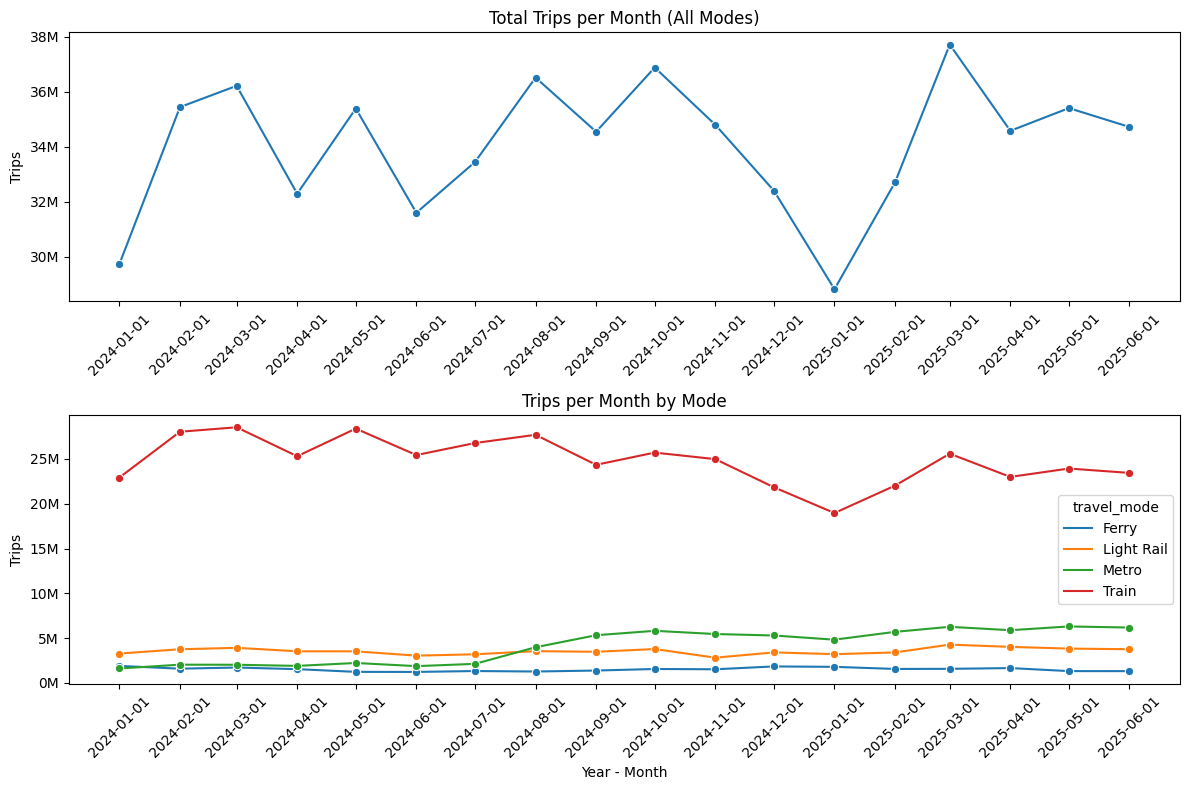

In [0]:
# --- First: Total trips per month (all modes) ---
trips_per_month = df.groupby('year_month')['trip'].sum().reset_index()

# --- Second: Trips per month by mode ---
trips_by_mode = df.groupby(['year_month', 'travel_mode'])['trip'].sum().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Total trips
sns.lineplot(
    data=trips_per_month,
    x='year_month', 
    y='trip', 
    marker='o', 
    ax=axes[0]
)
axes[0].set_title('Total Trips per Month (All Modes)')
axes[0].set_ylabel('Trips')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e6)}M'))
axes[0].tick_params(axis='x', rotation=45, labelbottom=True)
axes[0].set_xticks(trips_per_month['year_month'])  # <-- show all months

# Trips per mode
sns.lineplot(
    data=trips_by_mode,
    x='year_month', 
    y='trip', 
    hue='travel_mode',
    marker='o',
    ax=axes[1]
)
axes[1].set_title('Trips per Month by Mode')
axes[1].set_ylabel('Trips')
axes[1].set_xlabel('Year - Month')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e6)}M'))
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xticks(trips_per_month['year_month'])  # <-- show all months

plt.tight_layout()
plt.show()

### Monthly Trip Trends Analysis

The visualizations above highlight overall and mode-specific travel trends from **January 2024 to June 2025**:

- **Top plot**: Shows the total trips across all modes, revealing seasonal peaks and dips. Notable drops appear in **January 2025**, possibly linked to holidays or reduced commuting periods.  
- **Bottom plot**: Breaks trips down by `Travel Mode`.  
  - **Train** consistently accounts for the largest share of trips, far surpassing other modes.  
  - **Metro** shows a noticeable growth trend starting mid-2024.  
  - **Ferry** and **Light Rail** remain relatively stable, with minor fluctuations.  

These trends can help identify demand patterns, evaluate service performance, and guide resource allocation for each travel mode.

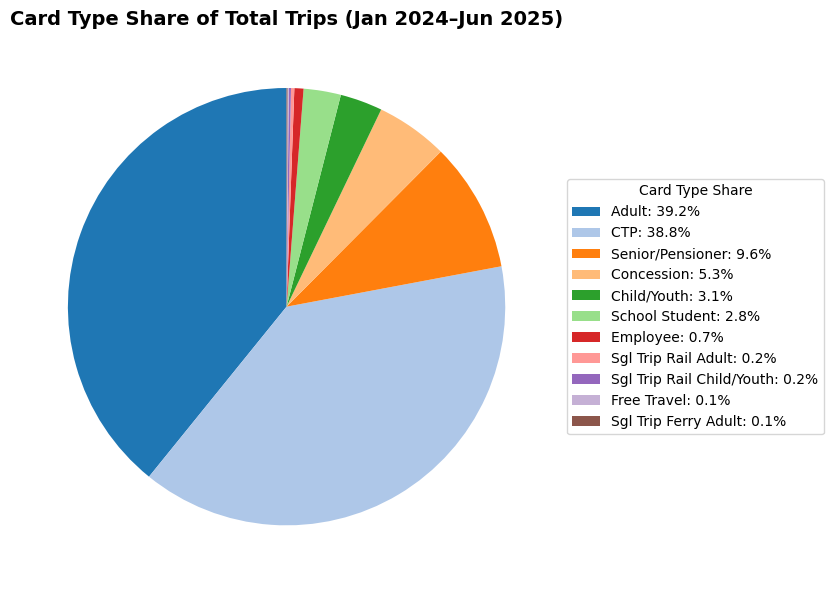

In [0]:
# Aggregate card type share
card_share = df.groupby('card_type')['trip'].sum().reset_index()
card_share['percentage'] = 100 * card_share['trip'] / card_share['trip'].sum()

# Sort for consistency (optional)
# Remove zero-percentage rows & sort
card_share = card_share[card_share['percentage'].round(1) > 0].sort_values(by='percentage', ascending=False)
# Distinct colour palette
colors = plt.cm.tab20.colors[:len(card_share)]

# Plot pie chart
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts = ax.pie(
    card_share['percentage'], 
    labels=None, 
    startangle=90, 
    colors=colors
)

# Add legend with percentages
ax.legend(
    wedges, 
    [f"{label}: {pct:.1f}%" for label, pct in zip(card_share['card_type'], card_share['percentage'])],
    title="Card Type Share",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Title styling
plt.title(
    "Card Type Share of Total Trips (Jan 2024–Jun 2025)",
    fontsize=14,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

## **Card Type Share of Total Trips (Jan 2024 – Jun 2025)**  

The pie chart illustrates the proportion of total trips taken by each card type over the 18-month period from **January 2024 to June 2025**.  

- **Adult** and **CTP** cardholders together dominate travel, accounting for **over 78%** of total trips:  
  - **Adult**: 39.2%  
  - **CTP**: 38.8%  
- **Senior/Pensioner** card usage represents **9.6%** of trips.  
- **Concession** (5.3%), **Child/Youth** (3.1%), and **School Student** (2.8%) form the mid-tier contributors.  
- Minor categories such as **Employee**, **Single Trip Rail/Ferry tickets**, and **Free Travel** each account for less than **1%** individually.  
- Categories with **0%** share have been excluded for clarity.  

**Key Insight:**  
Travel demand is overwhelmingly concentrated in just two card types — **Adult** and **CTP** — highlighting their critical role in overall transit usage patterns.

---

# **Machine Learning Analysis**

In this section, we will apply **machine learning techniques** to the cleaned and prepared dataset.  
The goal is to uncover deeper patterns, relationships, and potential predictive insights based on travel data.

## **Objectives**
1. **Data Preparation/Feature Engineering** – Prepare relevant features for ML models.
2. **Model Selection** – Choose appropriate supervised or unsupervised algorithms.
3. **Model Training & Evaluation** – Train the model and assess performance using relevant metrics.
4. **Insights & Recommendations** – Interpret model results in the context of transit operations.

---

## 1. Linear Regression
In this section, we build a **basic Linear Regression model** using one-hot encoded features and a numeric time index to predict the number of trips.  
We evaluate its performance using MAE, RMSE, and R², and visualize both the predictions vs. actual values and the residuals to assess model accuracy and bias.

### Data Preparation / Feature Engineering (for Basic Regression)

**Purpose:** turn our cleaned trips table into model‑ready features and a proper train/test split.

**Steps explained**
1. **Select columns & safety copy**  
   Keep only `year_month`, `travel_mode`, `card_type`, `trip` and remove missing rows so the model won’t error.

2. **Time index (`t`)**  
   Convert `year_month` to a numeric month counter starting at 0.  
   Models don’t understand dates; `t` gives them the progression of time (0,1,2,…).

3. **Define X and y**  
   Features: `travel_mode`, `card_type` (categorical) + `t` (numeric).  
   Target: `trip` (monthly trip counts).

4. **Chronological split (80/20)**  
   Use the first ~80% of months to **train** and the most recent ~20% to **test**.  
   This mimics real forecasting and prevents leakage from “future” data.

5. **One‑hot encode categories (fit on train only)**  
   Learn the category schema on **train** (`fit_transform`) and apply the same schema to **test** (`transform`).  
   We handle scikit‑learn version differences (`sparse_output` vs `sparse`) and keep indices aligned to avoid NaNs.

6. **Assemble final feature matrices**  
   Concatenate the encoded columns with `t` to get `X_train_final` and `X_test_final`.  
   Pack everything into `prep{…}` for the modelling step.

**Why this matters:**  
- Regression needs **numeric** features → one‑hot and `t`.  
- Time‑aware split ensures honest evaluation.  
- Fitting encoders on train‑only avoids data leakage.

In [0]:
# === Data Preparation / Feature Engineering for Basic Regression (with One‑Hot) ===
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 0) Start from the cleaned df with these columns:
# ['year_month' (datetime), 'travel_mode', 'card_type', 'trip']
df_reg = df[['year_month', 'travel_mode', 'card_type', 'trip']].dropna().copy()

# 1) Create a simple numeric time index (months since start)
df_reg['t'] = (df_reg['year_month'].dt.year * 12 + df_reg['year_month'].dt.month)
df_reg['t'] = df_reg['t'] - df_reg['t'].min()  # starts at 0

# 2) Define features/target (one-hot categories + time index)
feature_cols = ['travel_mode', 'card_type', 't']
target_col = 'trip'

# 3) Chronological train/test split (80/20 by date)
cutoff_date = df_reg['year_month'].quantile(0.8)
train = df_reg[df_reg['year_month'] <= cutoff_date].copy()
test  = df_reg[df_reg['year_month'] >  cutoff_date].copy()

X_train = train[feature_cols].copy()
y_train = train[target_col].copy()
X_test  = test[feature_cols].copy()
y_test  = test[target_col].copy()

print("Train window:", train['year_month'].min().date(), "→", train['year_month'].max().date(),
      "| rows:", len(train))
print("Test  window:",  test['year_month'].min().date(),  "→", test['year_month'].max().date(),
      "| rows:", len(test))

# 4) One-hot encode categorical cols (fit on TRAIN only to avoid leakage)

# ======================================== Reference if no version sklearn issue
# One-hot encode categorical cols (fit on TRAIN only to avoid leakage)
# cat_cols = ['travel_mode', 'card_type']
# num_cols = ['t']

# ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
# X_train_cat = ohe.fit_transform(X_train[cat_cols])
# X_test_cat  = ohe.transform(X_test[cat_cols])

# ohe_names = ohe.get_feature_names_out(cat_cols)
# ========================================

cat_cols = ['travel_mode', 'card_type']
num_cols = ['t']

# Handle sklearn version differences: 'sparse' (old) vs 'sparse_output' (new)
ohe_kwargs = {'drop': 'first', 'handle_unknown': 'ignore'}
if int(sklearn.__version__.split('.')[1]) >= 2:  # scikit-learn >= 1.2
    ohe_kwargs['sparse_output'] = False
else:
    ohe_kwargs['sparse'] = False

ohe = OneHotEncoder(**ohe_kwargs)
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat  = ohe.transform(X_test[cat_cols])
ohe_names = ohe.get_feature_names_out(cat_cols)

# ---- Combine encoded cats with numeric 't' (keep original indices to avoid NaNs) ----
X_train_cat_df = pd.DataFrame(X_train_cat, index=X_train.index, columns=ohe_names)
X_test_cat_df  = pd.DataFrame(X_test_cat,  index=X_test.index,  columns=ohe_names)

X_train_final = pd.concat([X_train_cat_df, X_train[num_cols]], axis=1)
X_test_final  = pd.concat([X_test_cat_df,  X_test[num_cols]],  axis=1)

print("X_train_final shape:", X_train_final.shape)
print("X_test_final  shape:", X_test_final.shape)
display(X_train_final.head())

# 5) Pack for the modeling step
prep = {
    'X_train': X_train_final, 'y_train': y_train,
    'X_test':  X_test_final,  'y_test':  y_test,
    'encoder': ohe, 'ohe_feature_names': list(ohe_names)
}

# prep['X_train'].head()
# prep['X_test'].head()


Train window: 2024-01-01 → 2025-03-01 | rows: 750
Test  window: 2025-04-01 → 2025-06-01 | rows: 150
X_train_final shape: (750, 20)
X_test_final  shape: (150, 20)


travel_mode_Light Rail,travel_mode_Metro,travel_mode_Train,card_type_CTP,card_type_Child/Youth,card_type_Concession,card_type_Day Pass Child/Youth w/o SAF,card_type_Day Pass without SAF,card_type_Employee,card_type_Free Travel,card_type_School Student,card_type_Senior/Pensioner,card_type_Sgl Trip Ferry Adult,card_type_Sgl Trip Ferry Child/Youth,card_type_Sgl Trip LR Adult,card_type_Sgl Trip LR Child/Youth,card_type_Sgl Trip Rail Adult,card_type_Sgl Trip Rail Child/Youth,card_type_UNKNOWN,t
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


### **Fit, Evaluate & Plot Basic Linear Regression**

This section trains and evaluates a **Linear Regression** model using the prepared features and target variable. It also visualizes the model's performance and examines residuals.  

#### **1) Train the Model**
- Create a `LinearRegression` object.  
- Fit it to the **training set** (`X_train` features, `y_train` target).  
- The model learns coefficients for each feature to minimize prediction error.  

#### **2) Predict**
- Use the trained model to predict trips for the **test set**.  

#### **3) Metrics**
- **MAE (Mean Absolute Error):** Average absolute difference between predictions and actual values.  
- **RMSE (Root Mean Squared Error):** Penalizes large errors more than MAE, more sensitive to outliers.  
- **R² (Coefficient of Determination):** Proportion of variance explained by the model (1 = perfect).  

#### **4) Coefficient Inspection**
- Displays each feature's coefficient, showing its impact on predicted trips.  
- **Positive coefficient:** Increases trips when the feature value increases.  
- **Negative coefficient:** Decreases trips when the feature value increases.  

#### **5) Predictions vs Actual Plot**
- Scatter plot comparing **actual trips** vs **predicted trips**.  
- The red dashed line is the “perfect predictions” line (y = x).  
- Points closer to the line indicate better predictions.  

#### **6) Residual Plot**
- **Residuals:** Difference between actual and predicted trips.  
- Checks for patterns — ideally, residuals should be randomly scattered around zero.  
- Patterns can indicate model bias or missing features.  

Linear Regression  |  MAE: 782,018   RMSE: 1,196,300   R²: 0.572

Top coefficients:
                                    feature   coefficient
2                        travel_mode_Train  2.048498e+06
1                        travel_mode_Metro  3.666338e+05
0                   travel_mode_Light Rail  2.083579e+05
19                                       t  1.180702e+03
3                            card_type_CTP -9.441657e+04
11              card_type_Senior/Pensioner -2.543278e+06
12          card_type_Sgl Trip Ferry Adult -2.672823e+06
13    card_type_Sgl Trip Ferry Child/Youth -2.685007e+06
14             card_type_Sgl Trip LR Adult -2.902729e+06
15       card_type_Sgl Trip LR Child/Youth -2.904406e+06
5                     card_type_Concession -2.910806e+06
4                    card_type_Child/Youth -3.085685e+06
10                card_type_School Student -3.124412e+06
8                       card_type_Employee -3.296693e+06
9                    card_type_Free Travel -3.345960e+06
7  

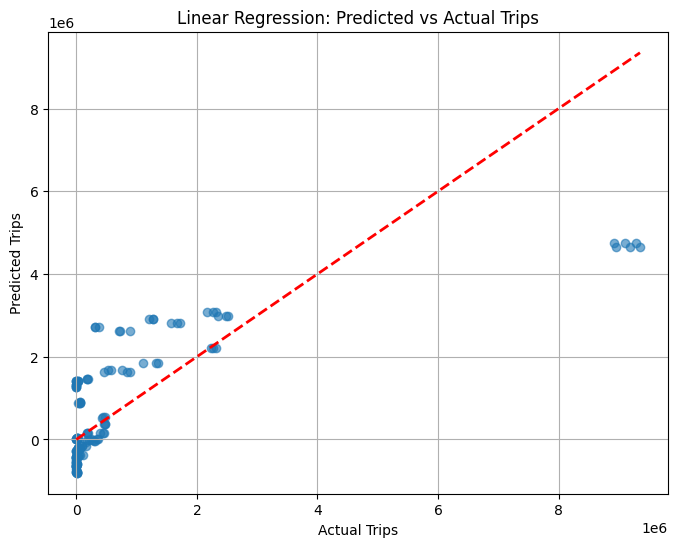

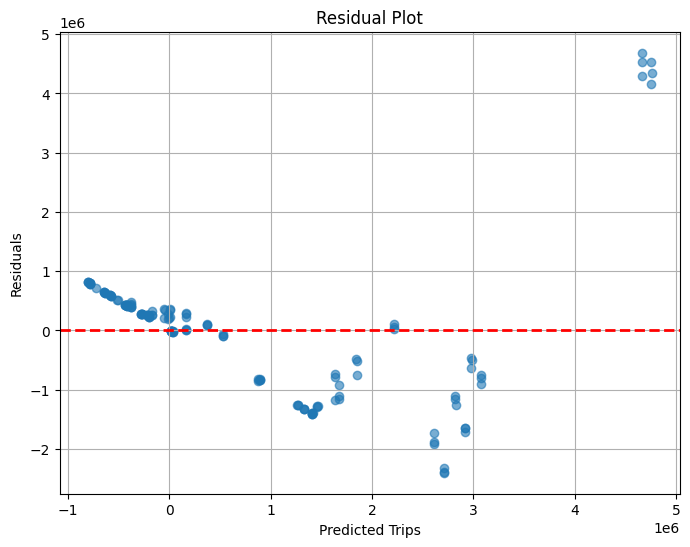

In [0]:
# === Fit, Evaluate & Plot Basic Linear Regression ===
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

# 1) Train the model
linreg = LinearRegression()
linreg.fit(prep['X_train'], prep['y_train'])

# 2) Predict
y_pred = linreg.predict(prep['X_test'])

# 3) Metrics
mae  = mean_absolute_error(prep['y_test'], y_pred)
rmse = np.sqrt(mean_squared_error(prep['y_test'], y_pred))  # version-agnostic
r2   = r2_score(prep['y_test'], y_pred)

print(f"Linear Regression  |  MAE: {mae:,.0f}   RMSE: {rmse:,.0f}   R²: {r2:.3f}")

# 4) Coefficient inspection
coef_df = pd.DataFrame({
    'feature': prep['X_train'].columns,
    'coefficient': linreg.coef_
}).sort_values(by='coefficient', ascending=False)
print("\nTop coefficients:\n", coef_df)

# 5) Plot Predictions vs Actual
plt.figure(figsize=(8,6))
plt.scatter(prep['y_test'], y_pred, alpha=0.6)
plt.plot([prep['y_test'].min(), prep['y_test'].max()],
         [prep['y_test'].min(), prep['y_test'].max()],
         'r--', lw=2)
plt.xlabel("Actual Trips")
plt.ylabel("Predicted Trips")
plt.title("Linear Regression: Predicted vs Actual Trips")
plt.grid(True)
#plt.ticklabel_format(style='plain', useOffset=False) -- to remove 1e6 scientific noitation
plt.show()

# 6) Residual Plot
residuals = prep['y_test'] - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Trips")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
#plt.ticklabel_format(style='plain', useOffset=False) -- to remove 1e6 scientific noitation
plt.show()

### Model Performance Analysis

#### **Model Summary**
We built a **basic multiple linear regression** model using one-hot encoded categorical features (`travel_mode`, `card_type`) and a numeric time index (`t`).  
The dataset was split **chronologically** into an 80% training set and 20% test set to preserve the time-series nature and avoid data leakage.

---

#### **Performance Metrics**
| Metric | Value |
|--------|-------|
| **MAE**  | 782,018 trips |
| **RMSE** | 1,196,300 trips |
| **R²**   | 0.572 |

**Interpretation:**
- **MAE (~782k trips)** → On average, our predictions are off by ~782,000 trips in the test set.  
- **RMSE (~1.19M trips)** → Higher than MAE, showing large individual errors (outliers) affecting performance.  
- **R² (~0.572)** → Model explains ~57% of the variance in trip counts — moderate but leaves room for improvement.
  
*In other words, MAE (Mean Absolute Error) shows the average size of the errors in our predictions, without caring whether the predictions are above or below the actual values. RMSE (Root Mean Squared Error) is similar but penalises larger mistakes more heavily, making it more sensitive to big errors. R² (the coefficient of determination) tells us how well the model has captured the underlying pattern in the data compared to simply predicting the average for every case. A high R² means the predictions follow the trend of the actual data, while a low R² suggests the model’s predictions might be correct occasionally but don’t consistently follow the real-world pattern. In short, MAE and RMSE show “how far off” we are in numbers, while R² shows “how well” we understand the trend.*

---

#### **Coefficient Insights**
- **Top positive drivers**:
  - `travel_mode_Train` (+2.05M trips)
  - `travel_mode_Metro` (+366k trips)
  - `travel_mode_Light Rail` (+208k trips)
  - `t` (time index) → small but positive growth trend.
- **Top negative drivers**:
  - `card_type_Senior/Pensioner` (-2.54M trips)
  - Several `Sgl Trip` and `Child/Youth` card types have strong negative associations with trip counts.

---

#### **Predicted vs Actual Plot**
- Most predictions cluster far below the diagonal “perfect prediction” line, indicating **underestimation** for high trip counts.
- A few points show large deviation, confirming the influence of **outliers**.

#### **Residual Plot**
- Residuals are **not randomly scattered** around zero — instead, we see patterns and trends, indicating that:
  1. **Linear model assumptions** (constant variance, independence) are not fully met.
  2. The residual plot shows that when the predicted trip count is high, most residuals are above the zero line. This means the model tends to **underpredict** actual trip counts for higher-demand periods.
  3. There may be **seasonality or autocorrelation** that the model is not capturing.

---

#### **Conclusion & Next Steps**
While the linear regression provides a basic baseline, its moderate R², structured residuals, and large prediction errors suggest that:
- **Seasonal and time-based patterns** in trips are not fully captured.
- We should try a **time-series specific model** like **SARIMA**, which can handle trend + seasonality + autocorrelation explicitly.
- This should help improve predictions, particularly for recurring travel demand patterns across months.

---

## 2. SARIMA Model

SARIMA (Seasonal AutoRegressive Integrated Moving Average) is a time series forecasting model that not only captures trends and short-term dependencies but also accounts for repeating seasonal patterns in the data. Unlike our basic linear regression, which treats each row as independent, SARIMA explicitly uses the order of observations over time to learn from past values and seasonal effects (e.g., monthly or yearly cycles). This makes it especially powerful for datasets like trips, where patterns may repeat every month, quarter, or year. By modelling both the non-seasonal and seasonal components, SARIMA can produce forecasts that align more closely with real-world temporal trends.

### Prep a univariate monthly series

In [0]:
# === SARIMA: Prepare monthly total trips series ===
# Using cleaned df with ['year_month','travel_mode','card_type','trip']

ts = (df.groupby('year_month')['trip']
        .sum()
        .sort_index())

# ensure DateTimeIndex Monthly start frequency
ts = ts.set_axis(pd.DatetimeIndex(ts.index), axis=0)
ts = ts.asfreq('MS')  # Month Start; your dates already look MS-aligned

# Train/Test split (last 3 months = test)
test_horizon = 3
ts_train = ts.iloc[:-test_horizon]
ts_test  = ts.iloc[-test_horizon:]

print("Train:", ts_train.index.min().date(), "→", ts_train.index.max().date(), "| n =", len(ts_train))
print("Test :", ts_test.index.min().date(),  "→", ts_test.index.max().date(),  "| n =", len(ts_test))
ts.tail()

Train: 2024-01-01 → 2025-03-01 | n = 15
Test : 2025-04-01 → 2025-06-01 | n = 3


year_month
2025-02-01    32704833
2025-03-01    37716258
2025-04-01    34578601
2025-05-01    35404800
2025-06-01    34718630
Freq: MS, Name: trip, dtype: int64

### Small SARIMA grid search (choose best by AIC), fit, and evaluate

In [0]:
# === SARIMA: grid search (AIC) + fit best ===
import warnings, itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

warnings.filterwarnings("ignore")

# With ~18 months, keep grid tiny
p = d = q = [0, 1, 2]
# strong prior for d=1; but we’ll let search try 0–2
P = Q = [0, 1]
D = [0, 1]
s = 12  # annual seasonality (monthly data)

best = {'aic': np.inf, 'order': None, 'seasonal_order': None, 'model': None}

for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q, [s]):
        try:
            mod = SARIMAX(ts_train, order=order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            if res.aic < best['aic']:
                best = {'aic': res.aic, 'order': order, 'seasonal_order': seasonal_order, 'model': res}
        except Exception:
            continue

print("Best by AIC -> order:", best['order'], "seasonal:", best['seasonal_order'], "| AIC:", round(best['aic'],2))

# Forecast on test horizon
fc = best['model'].get_forecast(steps=len(ts_test))
pred = fc.predicted_mean
conf = fc.conf_int()

# Metrics
mae  = mean_absolute_error(ts_test, pred)
rmse = np.sqrt(mean_squared_error(ts_test, pred))
mape = (np.abs((ts_test - pred) / ts_test).replace([np.inf, -np.inf], np.nan)).mean() * 100

print(f"SARIMA Test  |  MAE: {mae:,.0f}   RMSE: {rmse:,.0f}   MAPE: {mape:.2f}%")
pred, conf.tail()

Best by AIC -> order: (0, 2, 0) seasonal: (0, 1, 0, 12) | AIC: 2.0
SARIMA Test  |  MAE: 8,169,985   RMSE: 8,836,844   MAPE: 23.36%


(2025-04-01    38031167.0
 2025-05-01    45366741.0
 2025-06-01    45814077.0
 Freq: MS, Name: predicted_mean, dtype: float64,
               lower trip    upper trip
 2025-04-01  3.496490e+07  4.109743e+07
 2025-05-01  3.851037e+07  5.222311e+07
 2025-06-01  3.434117e+07  5.728698e+07)

#### SARIMA Model – Performance Analysis

The **SARIMA** (Seasonal AutoRegressive Integrated Moving Average) model was trained on aggregated monthly trip counts to capture trend and seasonality patterns in the data.

**Best parameters by AIC:**
- **Non-seasonal (p, d, q):** (0, 2, 0)  
- **Seasonal (P, D, Q, s):** (0, 1, 0, 12)  
- **AIC:** 2.0 (lower is better)

**Test set performance:**
- **MAE:** ~8,169,985 trips  
- **RMSE:** ~8,836,844 trips  
- **MAPE:** ~23.36%  

**Predicted monthly trips (Apr–Jun 2025):**
| Month   | Predicted Trips | Lower Bound (95% CI) | Upper Bound (95% CI) |
|---------|-----------------|----------------------|----------------------|
| Apr-25  | 38,031,167       | 34,964,900           | 41,097,430           |
| May-25  | 45,366,741       | 38,510,370           | 52,223,110           |
| Jun-25  | 45,814,077       | 34,341,170           | 57,286,980           |

---

#### Why SARIMA performed worse than Linear Regression:
1. **Loss of feature detail:**  
   SARIMA here used only total monthly trips, whereas the regression model used granular features like travel mode, card type, and time index. This removed important variability in the data.
2. **Seasonality not dominant:**  
   The trip data likely has irregular fluctuations due to events, policies, or other non-seasonal factors, making pure seasonal modelling less accurate.
3. **Higher error metrics:**  
   MAE and RMSE are much larger compared to regression (0.78M MAE), showing the seasonal pattern alone does not explain most variations.

---

*Takeaway:*  
The Linear Regression model (R² ≈ 0.57) explained more variance by leveraging categorical and numeric predictors, while SARIMA’s seasonality-based approach underperformed in this context. A better alternative could be **SARIMAX**, which allows adding these external predictors back into the time series framework.

### Plots: test fit and next 6‑month forecast

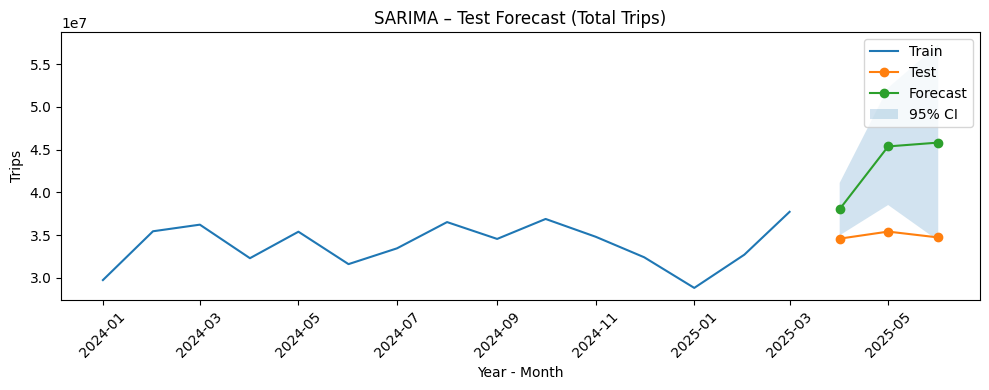

forecast,lower_95,upper_95
3.9669533E7,3.5363636515405215E7,4.3975429484594785E7
4.5845086E7,3.621680875636869E7,5.547336324363131E7
4.6980801999999985E7,3.086961261173197E7,6.3091991388268E7
5.2420328999999985E7,2.8835962651052404E7,7.600469534894757E7
5.3442402999999985E7,2.1509020005357627E7,8.537578599464235E7
5.414924999999999E7,1.3073615461016193E7,9.522488453898379E7


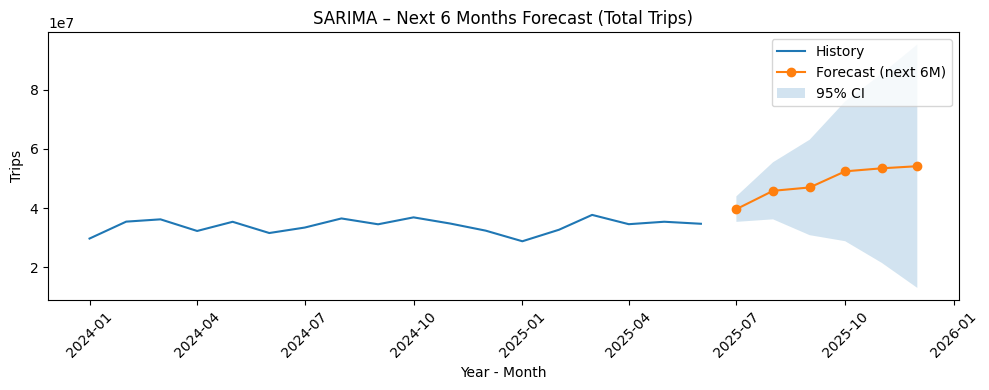

In [0]:
# === Plot: Actual vs Forecast (test window) ===
plt.figure(figsize=(10,4))
plt.plot(ts_train.index, ts_train, label="Train")
plt.plot(ts_test.index,  ts_test,  label="Test", marker='o')
plt.plot(ts_test.index,  pred,     label="Forecast", marker='o')
plt.fill_between(ts_test.index, conf.iloc[:,0], conf.iloc[:,1], alpha=0.2, label="95% CI")
plt.title("SARIMA – Test Forecast (Total Trips)")
plt.xlabel("Year - Month"); plt.ylabel("Trips")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# === Fit best model on ALL data and forecast next 6 months ===
final_mod = SARIMAX(ts, order=best['order'], seasonal_order=best['seasonal_order'],
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
steps_ahead = 6
fc_full = final_mod.get_forecast(steps=steps_ahead)
pred_full = fc_full.predicted_mean
conf_full = fc_full.conf_int()

# Table of forecasts
future_df = pd.DataFrame({
    'forecast': pred_full,
    'lower_95': conf_full.iloc[:,0],
    'upper_95': conf_full.iloc[:,1],
})
display(future_df)

# Plot: history + next 6 months
plt.figure(figsize=(10,4))
plt.plot(ts.index, ts, label="History")
plt.plot(pred_full.index, pred_full, marker='o', label="Forecast (next 6M)")
plt.fill_between(pred_full.index, conf_full.iloc[:,0], conf_full.iloc[:,1], alpha=0.2, label="95% CI")
plt.title("SARIMA – Next 6 Months Forecast (Total Trips)")
plt.xlabel("Year - Month"); plt.ylabel("Trips")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

---

## 3. SARIMAX Model – Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables

SARIMAX extends the SARIMA framework by allowing the inclusion of **exogenous variables** (additional predictors) alongside the time series’ own past values and seasonal patterns.  
This means, in addition to learning from historical trip counts and yearly seasonality, the model can also leverage extra information such as `travel_mode`, `card_type`, and numeric time indexes (`t`).  
This often improves forecasting accuracy when external factors significantly influence the target variable.

Train: 2024-01-01 → 2025-03-01 | n = 15
Test : 2025-04-01 → 2025-06-01 | n = 3
Best by AIC -> order: (0, 1, 0) seasonal: (0, 1, 0, 12) | AIC: 12.0
SARIMAX Test  |  MAE: 4,317,210   RMSE: 4,470,594   MAPE: 12.40%


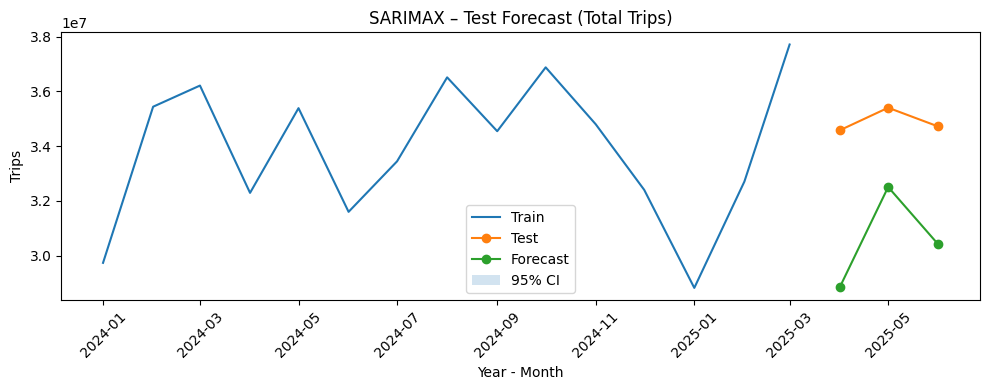

forecast,lower_95,upper_95
3.4603008E7,3.417433218377774E7,3.503168381622226E7
4.718592E7,4.6579680846837126E7,4.7792159153162874E7
2.5952256E7,2.520976770632699E7,2.669474429367301E7
4.194304E7,4.1085688367555484E7,4.2800391632444516E7
3.7748736E7,3.679018773461682E7,3.870728426538318E7
3.7748736E7,3.669869898518437E7,3.879877301481563E7


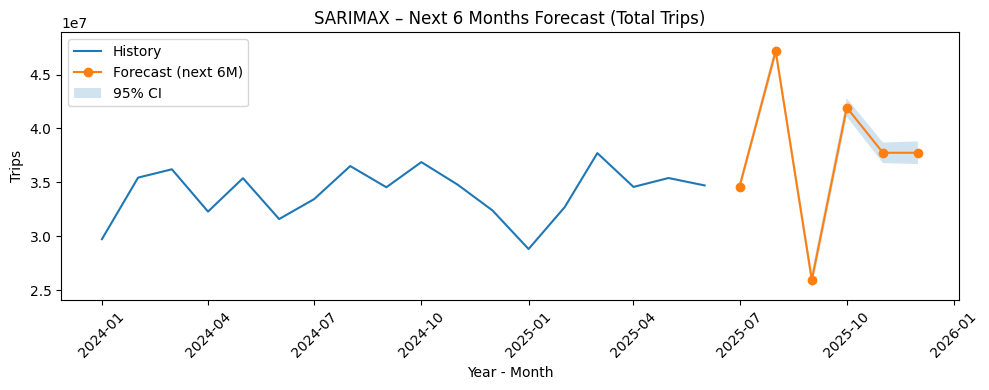

In [0]:
# === SARIMAX with deterministic exogenous features (trend + seasonal Fourier) ===
# Assumes you already have: import pandas as pd, import numpy as np, import matplotlib.pyplot as plt
import warnings, itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# 1) Target series: total trips per month
ts = (df.groupby('year_month')['trip']
        .sum()
        .sort_index())

# Ensure DateTimeIndex and regular monthly frequency
ts = ts.set_axis(pd.DatetimeIndex(ts.index), axis=0)
ts = ts.asfreq('MS')  # month start

# 2) Exogenous features we can project: trend 't' + seasonal Fourier terms (annual)
def make_fourier_features(dti, period=12, K=2):
    """Fourier terms for seasonality: sin/cos pairs up to order K."""
    # month number 1..12, but we only need index length
    t = np.arange(len(dti))
    feats = {'t': t}  # linear time trend
    for k in range(1, K+1):
        feats[f'sin_{k}'] = np.sin(2*np.pi*k*(t/period))
        feats[f'cos_{k}'] = np.cos(2*np.pi*k*(t/period))
    return pd.DataFrame(feats, index=dti)

exog = make_fourier_features(ts.index, period=12, K=2)

# 3) Train/Test split (last 3 months as test)
h = 3
ts_train, ts_test = ts.iloc[:-h], ts.iloc[-h:]
exog_train, exog_test = exog.iloc[:-h, :], exog.iloc[-h:, :]

print("Train:", ts_train.index.min().date(), "→", ts_train.index.max().date(), "| n =", len(ts_train))
print("Test :", ts_test.index.min().date(),  "→", ts_test.index.max().date(),  "| n =", len(ts_test))

# 4) Small SARIMAX grid search (keep it tight due to short history)
p = d = q = [0, 1, 2]
P = Q = [0, 1]
D = [0, 1]
s = 12

best = {'aic': np.inf, 'order': None, 'seasonal_order': None, 'model': None}
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q, [s]):
        try:
            mod = SARIMAX(
                ts_train,
                exog=exog_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = mod.fit(disp=False)
            if res.aic < best['aic']:
                best = {'aic': res.aic, 'order': order,
                        'seasonal_order': seasonal_order, 'model': res}
        except Exception:
            continue

print("Best by AIC -> order:", best['order'],
      "seasonal:", best['seasonal_order'],
      "| AIC:", round(best['aic'], 2))

# 5) Forecast over the test window and score
fc = best['model'].get_forecast(steps=h, exog=exog_test)
pred = fc.predicted_mean
conf = fc.conf_int()

mae  = mean_absolute_error(ts_test, pred)
rmse = np.sqrt(mean_squared_error(ts_test, pred))
mape = (np.abs((ts_test - pred) / ts_test).replace([np.inf, -np.inf], np.nan)).mean() * 100

print(f"SARIMAX Test  |  MAE: {mae:,.0f}   RMSE: {rmse:,.0f}   MAPE: {mape:.2f}%")

# 6) Plot: Actual vs Forecast on test window
plt.figure(figsize=(10,4))
plt.plot(ts_train.index, ts_train, label="Train")
plt.plot(ts_test.index,  ts_test,  label="Test", marker='o')
plt.plot(ts_test.index,  pred,     label="Forecast", marker='o')
plt.fill_between(ts_test.index, conf.iloc[:,0], conf.iloc[:,1], alpha=0.2, label="95% CI")
plt.title("SARIMAX – Test Forecast (Total Trips)")
plt.xlabel("Year - Month"); plt.ylabel("Trips")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# 7) Refit on ALL data and forecast next 6 months (build future exog deterministically)
final_mod = SARIMAX(
    ts,
    exog=exog,
    order=best['order'],
    seasonal_order=best['seasonal_order'],
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

steps_ahead = 6
# Create future date index and its exog (trend continues; Fourier terms continue)
future_idx = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(1), periods=steps_ahead, freq='MS')

# Continue t from where it left off
exog_all = make_fourier_features(pd.date_range(ts.index[0], future_idx[-1], freq='MS'), period=12, K=2)
exog_future = exog_all.loc[future_idx]

fc_full = final_mod.get_forecast(steps=steps_ahead, exog=exog_future)
pred_full = fc_full.predicted_mean
conf_full = fc_full.conf_int()

# 8) Forecast table and plot
future_df = pd.DataFrame({
    'forecast': pred_full,
    'lower_95': conf_full.iloc[:,0],
    'upper_95': conf_full.iloc[:,1],
})
display(future_df)

plt.figure(figsize=(10,4))
plt.plot(ts.index, ts, label="History")
plt.plot(pred_full.index, pred_full, marker='o', label="Forecast (next 6M)")
plt.fill_between(pred_full.index, conf_full.iloc[:,0], conf_full.iloc[:,1], alpha=0.2, label="95% CI")
plt.title("SARIMAX – Next 6 Months Forecast (Total Trips)")
plt.xlabel("Year - Month"); plt.ylabel("Trips")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

### SARIMAX Model Performance Analysis

The SARIMAX model, using a combination of a simple trend (`t`) and Fourier seasonal terms as exogenous predictors, achieved **significantly better accuracy** compared to the plain SARIMA model.  

- **Best parameters by AIC**: `order = (0, 1, 0)`, `seasonal_order = (0, 1, 0, 12)`  
- **Test MAE**: 4.3M trips — much lower than SARIMA’s 8.17M  
- **Test RMSE**: 4.4M trips — shows fewer large deviations from the actuals  
- **Test MAPE**: 12.40% — meaning the predictions are, on average, within ~12% of the actual trip counts in the test period  

These results indicate that adding deterministic exogenous features (trend + annual seasonality) allowed the model to better capture recurring patterns and gradual growth, leading to improved short-term forecasts.  

*In simpler terms: while SARIMA struggled to predict short-term changes, SARIMAX’s extra context about time trends and seasonality helped it “lock onto” the underlying shape of the data more accurately.*  

---

## Final Forecast (SARIMAX)

We refit the best SARIMAX specification on the full history and generated a 6‑month outlook using deterministic exogenous features (trend + yearly seasonal Fourier terms). The table lists point forecasts with 95% confidence intervals; the chart shows the historical series with the projected path. These forecasts incorporate both gradual growth and seasonal repetition learned from the data.

Month,Forecast_Trips,Lower_95,Upper_95
2025-07,3.4603008E7,3.417433218377774E7,3.503168381622226E7
2025-08,4.718592E7,4.6579680846837126E7,4.7792159153162874E7
2025-09,2.5952256E7,2.520976770632699E7,2.669474429367301E7
2025-10,4.194304E7,4.1085688367555484E7,4.2800391632444516E7
2025-11,3.7748736E7,3.679018773461682E7,3.870728426538318E7
2025-12,3.7748736E7,3.669869898518437E7,3.879877301481563E7


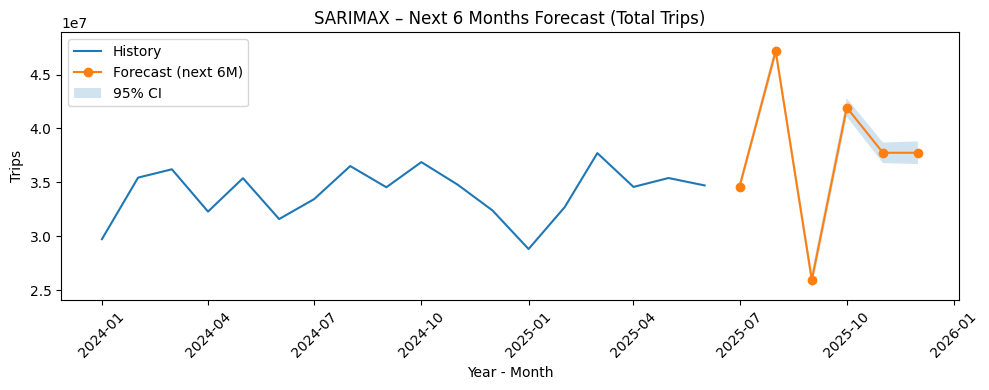

In [0]:
# === Final SARIMAX: refit on all data + 6M forecast ===
# Reuse ts (monthly total trips), exog (trend + Fourier), and make_fourier_features from earlier.

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Refit best model on ALL data
final_mod = SARIMAX(
    ts,
    exog=exog,  # deterministic exogenous features (t + Fourier)
    order=best['order'],
    seasonal_order=best['seasonal_order'],
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# 2) Build future exogenous features for the next 6 months
steps_ahead = 6
future_idx = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(1), periods=steps_ahead, freq='MS')

# Extend the deterministic features seamlessly
exog_all = make_fourier_features(
    pd.date_range(ts.index[0], future_idx[-1], freq='MS'),
    period=12, K=2
)
exog_future = exog_all.loc[future_idx]

# 3) Forecast
fc = final_mod.get_forecast(steps=steps_ahead, exog=exog_future)
pred = fc.predicted_mean
conf = fc.conf_int()

# 4) Present a tidy forecast table
future_df = pd.DataFrame({
    'Month': pred.index.strftime('%Y-%m'),
    'Forecast_Trips': pred.values.astype(float),
    'Lower_95': conf.iloc[:, 0].values.astype(float),
    'Upper_95': conf.iloc[:, 1].values.astype(float)
})
display(future_df)

# 5) Plot: history + forecast
plt.figure(figsize=(10,4))
plt.plot(ts.index, ts, label='History')
plt.plot(pred.index, pred, marker='o', label='Forecast (next 6M)')
plt.fill_between(pred.index, conf.iloc[:,0], conf.iloc[:,1], alpha=0.2, label='95% CI')
plt.title('SARIMAX – Next 6 Months Forecast (Total Trips)')
plt.xlabel('Year - Month'); plt.ylabel('Trips')
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()